# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.added_points.append(PointsCollection([]))
         
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [34]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        if(len(points) > 0 and isinstance(points[0], Point)):
            self.points = [p.as_tuple() for p in points]
        else:   
            self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        return [b_prev, b_next, b_add_point]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def draw(self, limits=None):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        if limits is not None:
            ax.set_xlim(limits[0])
            ax.set_ylim(limits[1])
            self.callback.draw(False)
        else:
            self.callback.draw(True)

        

In [10]:
import random

force_int = True
EPS = 10**(-10)
class Point:
    def __init__(self, x, y):
        if(force_int):
            self.x = int(x)
            self.y = int(y)
        else:      
            self.x = x
            self.y = y
    def as_tuple(self):
        return (self.x, self.y)

    def __getitem__(self, index):
        if(index == 0): return self.x
        elif(index == 1): return self.y
        else: raise BaseException("error index __getitem__")
    def __repr__(self):
        return "p({},{})".format(self.x, self.y)
    def __len__(self):
        return 2
    def __eq__(self, other):
        return abs(self.x-other.x) < EPS and abs(self.y-other.y) < EPS
    
def points_as_list(points):
    return [ p.as_tuple() for p in points]

def points_to_PointsCollection(points):
    return PointsCollection(points_as_list(points))

def gen_points(num_of_points, minX, maxX, minY, maxY):
    points = []
    for _ in range(num_of_points):
        points.append( Point(random.uniform(minX, minX+maxX), random.uniform(minY, minY+maxY)) )
    return points


<IPython.core.display.Javascript object>


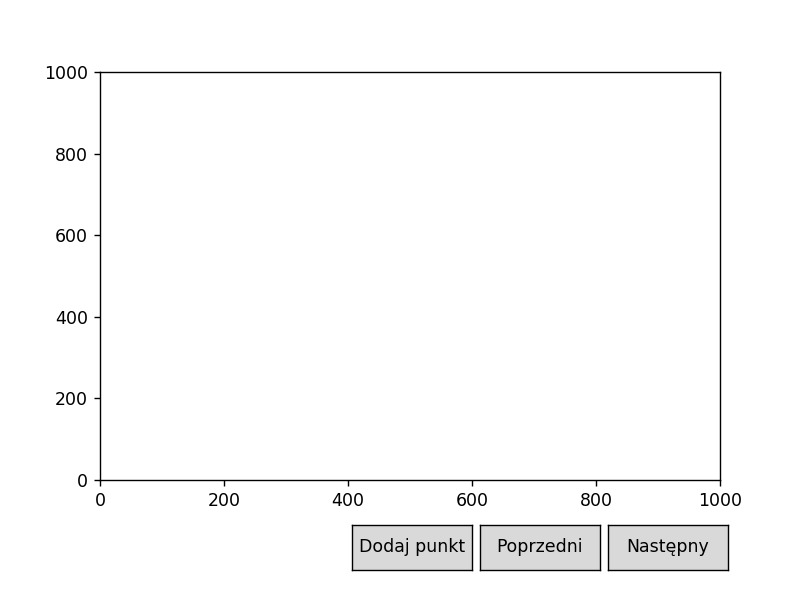

In [18]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw([(0,1000), (0,1000)])

<IPython.core.display.Javascript object>


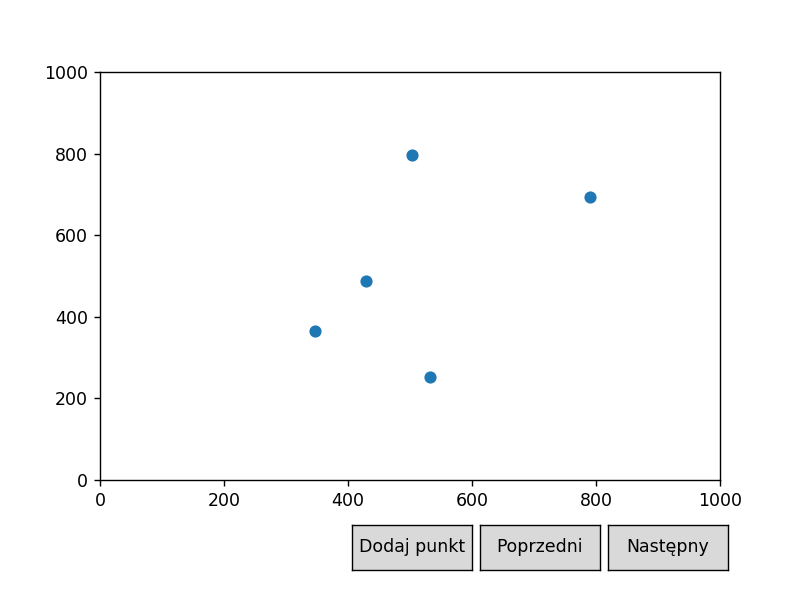

In [35]:
plot2 = Plot([Scene(points=plot1.get_added_points())])
plot2.draw([(0,1000), (0,1000)])

### Rozwiązanie

In [22]:
%matplotlib notebook

def get_points(plot):
    points_list = []
    for points_collection_list in plot.get_added_points() + plot.scenes[0].points:
        points_list += points_collection_list.points
    return [Point(p[0], p[1]) for p in  list(set(points_list))]

get_points(plot2)



[p(743,244),
 p(98,936),
 p(673,320),
 p(56,844),
 p(104,820),
 p(679,140),
 p(171,857),
 p(195,924),
 p(138,899),
 p(421,106),
 p(761,112),
 p(800,146),
 p(509,229),
 p(820,195)]

<IPython.core.display.Javascript object>


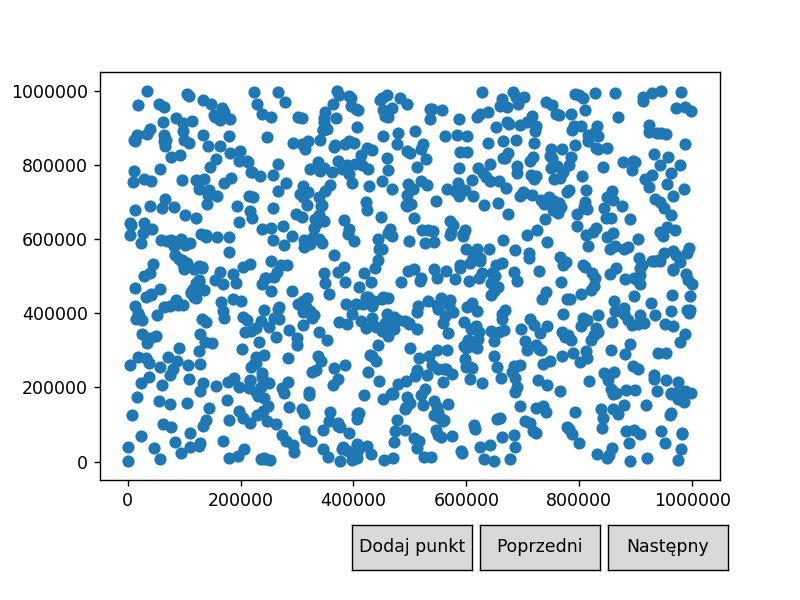

In [42]:
%matplotlib notebook
lis = gen_points(1000, 0, 1000000, 0, 1000000) 
scenes=[Scene([PointsCollection(lis)])]

plot = Plot(scenes)
plot.draw() 

In [39]:
class QT_Node:
    def __init__(self, center):
        self.NE_child = QT_Leaf()
        self.SE_child = QT_Leaf()
        self.NW_child = QT_Leaf()
        self.SW_child = QT_Leaf()
        self.center = center
    
    def add_one(self, point)
        this_node = None
        if(this_node.can_add_one()):
            this_node.add_one(point)
        else:
            node_points = this_node.points
            this_node = QT_Node()
            for(p in node_points):
                this_node.add_one(p)
            this_node.add_one(point)

class QT_Leaf:
    def __init__(self):
        self.points = []
    
    def can_add_one():
        return len(self.points < 2)
    
    def add_one(point):
        self.points.append(point)
        

class QT_Tree:
    

1574418731.533031